# Lab One : Visualization and Data Pre-processing

### Group 3 - Members:

_Apurv Mittal_<br>
_Seemant Srivastava_<br>
_Ravi Sivaraman_<br>
_Tai Chowdhury_<br>


In [1]:
# Import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from scipy import stats
import warnings
from shapely.geometry import Point
import plotly.express as px
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.model_selection import ShuffleSplit
from sklearn.utils import resample



In [2]:
#Ignore Warnings on final

warnings.filterwarnings('ignore')

In [3]:
# Read the Australia weather data
df = pd.read_csv("weatherAUS.csv")

In [4]:
#  View the top rows of the data imported
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,12/1/08,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,12/2/08,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,12/3/08,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,12/4/08,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,12/5/08,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [5]:
#Drop Date and Location

df = df.drop(['Date', 'Location'], axis = 1)

In [6]:
# Removing records which are blank for Rain today and Rain tomorrow

df.dropna(subset = ["RainToday"], inplace=True)
df.dropna(subset = ["RainTomorrow"], inplace=True)


# Seperate the data into categorical and numeric

df_num = df.columns[df.dtypes == 'float64']
df_cat=df.columns[df.dtypes == 'object']
print("Numeric Variables:", df_num)
print("Categorical Variables:", df_cat)

# REFERENCE: https://www.kite.com/python/answers/how-to-drop-empty-rows-from-a-pandas-dataframe-in-python

Numeric Variables: Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm'],
      dtype='object')
Categorical Variables: Index(['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow'], dtype='object')


#### Data Imputation

In [7]:
# Impute data (numeric) based on the mean for RainToday and RainTomorrow

df_impute = df
mat_yesno = df[df_num].groupby([df['RainToday'],df['RainTomorrow']]).mean()
RAINTODAY=0
RAINTOMORROW=1
COUNTER = 0
for i in range(2):
    for j in range(2):
        for indexattr in mat_yesno.iloc[COUNTER].index:
            df_impute.loc[(df_impute["RainToday"] == mat_yesno.iloc[COUNTER].name[RAINTODAY] ) 
                          & (df_impute["RainTomorrow"] == mat_yesno.iloc[COUNTER].name[RAINTOMORROW]) 
                          & (df_impute[indexattr].isnull()), indexattr] = mat_yesno.iloc[COUNTER][indexattr]
        COUNTER = COUNTER + 1

        
        
# Impute data (categorical) with mode of each variable

df_impute['WindDir9am'] = df_impute['WindDir9am'].fillna(df_impute['WindDir9am'].mode()[0])
df_impute['WindGustDir'] = df_impute['WindGustDir'].fillna(df_impute['WindGustDir'].mode()[0])
df_impute['WindDir3pm'] = df_impute['WindDir3pm'].fillna(df_impute['WindDir3pm'].mode()[0])

As mentioned above, we imputed data for all numeric variables with the means for the combination of `RainToday` and `RainTomorrow`. We calcualted the value for `RainToday` and `RainTomorrow` both as "No" and imputed the data for the missing variables for such combination, similary calculated `RainToday` as "Yes" and `RainTomorrow` as "No" and imputed the mean value for the variable so and so forth.

For categorical variables `WindDir9am`, `WindDir3pm` are covering the direction of the wind at different 9 am and 3 pm respectively, while `WindGustDir`is the direction of the wind gust. All these variables are about the direction and and the largest missing variable is `6.8%` for Wind Direction at 9 am. We decided to impute this data with the Mode for each of the categorical variable.


In [8]:
df_impute_num = df.columns[df.dtypes == 'float64']
df_impute_cat=df.columns[df.dtypes == 'object']
print("Numeric Variables:", df_num)
print("Categorical Variables:", df_cat)

Numeric Variables: Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm'],
      dtype='object')
Categorical Variables: Index(['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow'], dtype='object')


## Creating different dataframes for continous and categorical variables.
Assigning the `RainTomorrow` as our response variable (y) and all other continous variable as X

### Handling Class Imbalance For Rainfall Prediction

In [9]:
#Keep the original data
df_model = df_impute.copy()

In [10]:
#Change RainToday from categorical to continuous

df_model["IsRainToday"] = df_impute['RainToday']
#df_model['IsRainTomorrow'] = df_impute['RainTomorrow']

df_model['IsRainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
#df_model['IsRainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)

In [11]:
print("df_impute", df_impute.shape)
print("df_model", df_model.shape)


df_impute (140787, 21)
df_model (140787, 22)


In [12]:
df_model

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,IsRainToday
0,13.4,22.9,0.6,6.032209,8.890686,W,44.0,W,WNW,20.0,...,22.0,1007.7,1007.1,8.000000,3.684394,16.9,21.8,No,No,0
1,7.4,25.1,0.0,6.032209,8.890686,WNW,44.0,NNW,WSW,4.0,...,25.0,1010.6,1007.8,3.635105,3.684394,17.2,24.3,No,No,0
2,12.9,25.7,0.0,6.032209,8.890686,WSW,46.0,W,WSW,19.0,...,30.0,1007.6,1008.7,3.635105,2.000000,21.0,23.2,No,No,0
3,9.2,28.0,0.0,6.032209,8.890686,NE,24.0,SE,E,11.0,...,16.0,1017.6,1012.8,3.635105,3.684394,18.1,26.5,No,No,0
4,17.5,32.3,1.0,6.032209,8.890686,W,41.0,ENE,NW,7.0,...,33.0,1010.8,1006.0,7.000000,8.000000,17.8,29.7,No,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,3.5,21.8,0.0,6.032209,8.890686,E,31.0,ESE,E,15.0,...,27.0,1024.7,1021.2,3.635105,3.684394,9.4,20.9,No,No,0
145455,2.8,23.4,0.0,6.032209,8.890686,E,31.0,SE,ENE,13.0,...,24.0,1024.6,1020.3,3.635105,3.684394,10.1,22.4,No,No,0
145456,3.6,25.3,0.0,6.032209,8.890686,NNW,22.0,SE,N,13.0,...,21.0,1023.5,1019.1,3.635105,3.684394,10.9,24.5,No,No,0
145457,5.4,26.9,0.0,6.032209,8.890686,N,37.0,SE,WNW,9.0,...,24.0,1021.0,1016.8,3.635105,3.684394,12.5,26.1,No,No,0


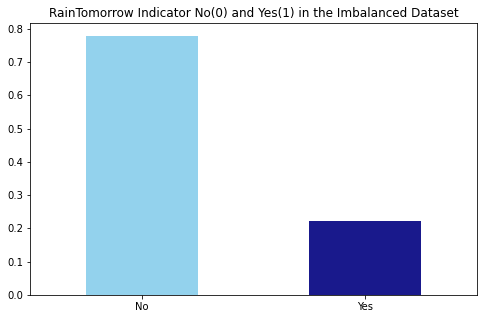

In [13]:
fig = plt.figure(figsize = (8,5))
df_model['RainTomorrow'].value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) in the Imbalanced Dataset')
plt.show()

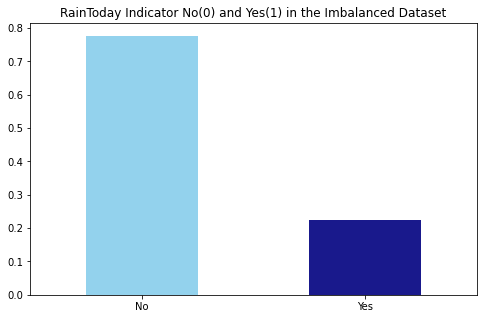

In [14]:
fig = plt.figure(figsize = (8,5))
df_model['RainToday'].value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainToday Indicator No(0) and Yes(1) in the Imbalanced Dataset')
plt.show()

We can observe that the presence of “0” and “1” is almost in the 78:22 ratio. So there is a class imbalance and we have to deal with it. To fight against the class imbalance, we will use here the oversampling of the minority class. Since the size of the dataset is quite small, majority class subsampling wouldn’t make much sense here.

## One hot encoding

In [15]:
# perform one-hot encoding of the categorical data

gust_df = pd.get_dummies(df_model.WindGustDir,prefix='GustDir')
wind3pm_df = pd.get_dummies(df_model.WindDir3pm,prefix='Wind3pm')
wind9am_df = pd.get_dummies(df_model.WindDir9am,prefix='Wind9am')
df_model = pd.concat((df_model,gust_df, wind3pm_df, wind9am_df),axis=1) # add back into the dataframe


In [16]:
# Drop categorical columns

df_model = df_model.drop(['WindDir3pm', 'WindDir9am', 'WindGustDir', 'RainToday'], axis = 1)

In [17]:
#Check if Yes is replaced as 1

print("Are there 1's and 0's in the RainToday column?", 
      (df_model['IsRainToday'].sum() > 0) and (df_model['IsRainToday'].sum() < len(df_model['IsRainToday'])))

#Non zero output means there is a mixture of 1's and 0's
#if sum is less

Are there 1's and 0's in the RainToday column? True


In [18]:
X=df_model[df_num]
y = df_model.RainTomorrow
print('features shape:', X.shape) 
print('target shape:', y.shape )

features shape: (140787, 16)
target shape: (140787,)


### Models

In [19]:
#Logistic Regression Function
#Run with various parameters
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

def create_models(model_type,df, iterations,class_weight, penalty, solver, C, l1_ratio):
    lr_clf = LogisticRegression(penalty=penalty, C=C, class_weight=class_weight, solver=solver) 

    num_cv_iterations = iterations
    rain_tom_df = None
   
    if "RainTomorrow" in df:
        y = df["RainTomorrow"].values # get the labels we want
        del df["RainTomorrow"] # get rid of the class label
        X = df.values # use everything else to predict!
    else:
        return

    num_instances = len(y)
    if model_type == "shuffle":
        cv_data = ShuffleSplit(n_splits=num_cv_iterations,
                             test_size  = 0.2, random_state = 123)

    elif model_type == "stratified":
        cv_data = StratifiedKFold(n_splits=iterations, random_state=123, shuffle=True)
        cv_data.get_n_splits(X, y)

       
    iter_num=0
    rows = []
    scl_obj = StandardScaler()
    for train_indices, test_indices in cv_data.split(X,y): 
        X_train = X[train_indices]
        y_train = y[train_indices]
        
        scl_obj.fit(X_train)

        X_test = X[test_indices]
        y_test = y[test_indices]
        try:
            X_train_scaled = scl_obj.transform(X_train) 
            X_test_scaled = scl_obj.transform(X_test)
            y_hat = None
            if model_type == "svm":
                svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
                svm_clf.fit(X_train_scaled, y_train)  # train object
                y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

            else:
                # shuffle and stratifed models using logistic reg
                lr_clf.fit(X_train_scaled,y_train)  # train object
                y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

            acc = mt.accuracy_score(y_test,y_hat)
            conf = mt.confusion_matrix(y_test,y_hat)
            target_names = ['No', 'Yes']
            class_report = classification_report(y_test, y_hat, target_names)
            
            # Create ROC Curve
            y_test_01 = np.where(y_test =="Yes", 1, [0])
            print("y_test", y_test)
            print("y_test_01", y_test_01)
            print("y_hat", y_hat)
            y_hat_01 = np.where(y_hat =="Yes", 1, [0])

            fpr, tpr, threshold = metrics.roc_curve(y_test_01, y_hat_01)
            print("fpr", fpr)
            print("tr", tpr)
            rows.append([model_type,solver,class_weight,C,penalty,iter_num, acc, conf, class_report, fpr,tpr])

            print("Iteration",solver,class_weight,C,penalty,iter_num,"-----> Done")
            disp = mt.ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=lr_clf.classes_)
            disp.plot()
        except Exception as e:
            print('Error:', str(e))
            raise
        iter_num+=1   
   
    df_ret = pd.DataFrame(rows, columns=["ModelType","Solver", "ClassWeight", "C", "Penalty","Iteration","Accuracy","ConfusionMatrix", 
                                         "ClassificationReport","fpr", "tpr"])
    return df_ret


In [ ]:
penalty=['l1','l2', 'elasticnet', 'none']
class_weight = ['balanced', None]
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
model_type = ['shuffle', 'stratified']

#penalty=['l2']
#class_weight = [None]
#solver = ['liblinear']
#model_type = ['shuffle', "stratified"]


lg_types = []
C=1.0

for pen in penalty:
    for cw in class_weight:
        for solv in solver:
            for split in model_type:
                lg_types.append([solv,cw,C,pen])
                try:
                    df_ret = create_models(model_type=split,df=df_model,iterations=3,class_weight=cw, penalty=pen, C=C, solver=solv, l1_ratio=None)
                    df_model["RainTomorrow"] = df_impute["RainTomorrow"].values
                    plt.title('Receiver Operating Characteristic (ROC)')
                    for index, row in df_ret.iterrows():
                        fpr = row["fpr"]
                        tpr = row["tpr"]
                        print("fpr", fpr)
                        print("tpr", tpr)
                        roc_auc = metrics.auc(fpr, tpr)
                        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
                        plt.legend(loc = 'lower right')
                        plt.plot([0, 1], [0, 1],'r--')
                        plt.xlim([0, 1])
                        plt.ylim([0, 1])
                        plt.ylabel('True Positive Rate')
                        plt.xlabel('False Positive Rate')
                        plt.show()
                except Exception as e:
                    print("Error in running", str(e))
                    continue
                            

df_ret_svm = create_models(model_type="svm", df=df_model, iterations=0,class_weight=None, penalty=None, C=0, solver=None, l1_ratio=None)
for index, row in df_ret_svm.iterrows():
    fpr = row["fpr"]
    tpr = row["tpr"]
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

lg_types_df = pd.DataFrame(lg_types, columns=["Solver", "ClassWeight", "C", "Penalty"])
#print(lg_types_df)          
 

#df_ret = [logistic_regression(df=df_impute,iterations=3,class_weight=row[0], penalty=row[1], C=row[2], solver=row[3], l1_ratio=None) for row in zip(lg_types_df['ClassWeight'],lg_types_df["Penalty"],lg_types_df['C'], lg_types_df["Solver"])]
#df_ret = logistic_regression(df=df_impute, iterations=3, class_weight='balanced',penalty='l2' ,C=1.0, solver='liblinear', l1_ratio=None)
#print(df_ret)


#Source for panda iterations https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas

Error: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.
Error in running Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.
Error in running 'NoneType' object has no attribute 'iterrows'
Error: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.
Error in running Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.
Error in running 'NoneType' object has no attribute 'iterrows'


In [ ]:
df_ret["fpr"]

In [ ]:
disp = mt.ConfusionMatrixDisplay(confusion_matrix=conf[1])
disp.plot()

In [ ]:
print(df_ret)

In [ ]:
df_model

## Alternative/Shorter version of logistic regression

In [ ]:
# this does the exact same thing as the above block of code, but with shorter syntax

for iter_num,(train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    lr_clf.fit([train_indices],y[train_indices])  # train object
    y_hat = lr_clf.predict([test_indices]) # get test set precitions

    # print the accuracy and confusion matrix 
    print("====Iteration",iter_num," ====")
    print("accuracy", mt.accuracy_score(y[test_indices],y_hat)) 
    print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))

In [ ]:
#Logistic Regression Function
#Run with various parameters
from sklearn.model_selection import cross_val_score

def logistic_regression_short(df, iterations,class_weight, penalty, solver, C, l1_ratio):
    lr_clf = LogisticRegression(penalty=penalty, C=C, class_weight=class_weight, solver=solver) 

  
    if "RainTomorrow" in df:
        y = df["RainTomorrow"].values # get the labels we want
        del df["RainTomorrow"] # get rid of the class label
        X = df.values # use everything else to predict!
    else:
        return

    rows = []
    iter_num = 0
    
    try:
        # train the reusable logisitc regression model on the training data
        accuracies = cross_val_score(lr_clf, X, y=y, cv=iterations) 
        for index, acc in enumerate(accuracies):
            rows.append([solver,class_weight,C,penalty,index, acc, None])
    except Exception as e:
        print("Error in running", solver,class_weight,C,penalty,iter_num, str(e))
        
        
    df_ret = pd.DataFrame(rows, columns=["Solver", "ClassWeight", "C", "Penalty","Iteration","Accuracy","ConfusionMatrix"])
    return df_ret

In [ ]:
# and here is an even shorter way of getting the accuracies for each training and test set

accuracies = logistic_regression_short() # this also can help with parallelism
print(accuracies)

## Stratified

In [ ]:
# Stratified CV 
from sklearn.model_selection import StratifiedKFold

def stratified_k_fold(iterations):
    
    skf = StratifiedKFold(n_splits=10, random_state=123, shuffle=True)
    skf.get_n_splits(X, y)

    for train_index, test_index in skf.split(X, y):
        print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]


In [ ]:
# here we can change some of the parameters interactively
from ipywidgets import widgets as wd

def lr_explor(cost):
    lr_clf = LogisticRegression(penalty='l2', C=cost, class_weight=None,solver='liblinear') # get object
    accuracies = cross_val_score(lr_clf,X_new,y=y,cv=cv_object) # this also can help with parallelism
    print(accuracies)

wd.interact(lr_explor,cost=(0.001,5.0,0.05),__manual=True)

### Interpreting the weights - Need to add explanations

In [ ]:

# interpret the weights

# iterate over the coefficients
weights = lr_clf.coef_.T # take transpose to make a column vector
variable_names = oversampled.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])
    
# does this look correct?

In [ ]:
#StandardScaler for df_impute

from sklearn.preprocessing import StandardScaler


# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
lr_clf = LogisticRegression(penalty='l2', C=0.05, solver='liblinear') # get object, the 'C' value is less (can you guess why??)
lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )

# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,df_impute.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them outv

In [ ]:
#StandardScaler for oversampled

from sklearn.preprocessing import StandardScaler


# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
lr_clf = LogisticRegression(penalty='l2', C=0.05, solver='liblinear') # get object, the 'C' value is less (can you guess why??)
lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )

# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,oversampled.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them outv

### Needs attention

In [ ]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


weights = pd.Series(lr_clf.coef_[0],index=oversampled.columns)
weights.plot(kind='bar')
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)

from sklearn.pipeline import Pipeline
# you can apply the StandardScaler function inside of the cross-validation loop 
#  but this requires the use of PipeLines in scikit. 
#  A pipeline can apply feature pre-processing and data fitting in one compact notation
#  Here is an example!

std_scl = StandardScaler()
lr_clf = LogisticRegression(penalty='l2', C=0.05, solver='liblinear') 

# create the pipline
piped_object = Pipeline([('scale', std_scl),  # do this
                         ('logit_model', lr_clf)]) # and then do this

weights = []
# run the pipline cross validated
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    piped_object.fit(X_new[train_indices],y[train_indices])  # train object
    # it is a little odd getting trained objects from a  pipeline:
    weights.append(piped_object.named_steps['logit_model'].coef_[0])
    

weights = np.array(weights)

## Needs Attention

In [ ]:
import plotly
plotly.offline.init_notebook_mode() # run at the start of every notebook

error_y=dict(
            type='data',
            array=np.std(weights,axis=0),
            visible=True
        )

graph1 = {'x': oversampled.columns,
          'y': np.mean(weights,axis=0),
    'error_y':error_y,
       'type': 'bar'}

fig = dict()
fig['data'] = [graph1]
fig['layout'] = {'title': 'Logistic Regression Weights, with error bars'}

plotly.offline.iplot(fig)

### Needs Attention***  need to decide on the attributes for Xnew. 

In [ ]:

Xnew = oversampled[['Year','WindGustSpeed','RainToday']].values

weights = []
# run the pipline corssvalidated
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(Xnew,y)):
    piped_object.fit(Xnew[train_indices],y[train_indices])  # train object
    weights.append(piped_object.named_steps['logit_model'].coef_[0])
    
weights = np.array(weights)

error_y=dict(
            type='data',
            array=np.std(weights,axis=0),
            visible=True
        )

graph1 = {'x': ['Year','WindGustSpeed','RainToday'],
          'y': np.mean(weights,axis=0),
    'error_y':error_y,
       'type': 'bar'}

fig = dict()
fig['data'] = [graph1]
fig['layout'] = {'title': 'Logistic Regression Weights, with error bars'}

plotly.offline.iplot(fig)

In [ ]:
import lime
from lime import lime_tabular

## SVM Models

In [ ]:
#SVM Using df_impute

# okay, so run through the cross validation loop and set the training and testing variable for one single iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test)

In [ ]:
##SVM Using df_impute dataframe

# lets investigate SVMs on the data and play with the parameters and kernels
from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

In [ ]:
#SVM Using oversampled dataframe

# okay, so run through the cross validation loop and set the training and testing variable for one single iteration
for train_indices, test_indices in cv_object.split_over(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test)

In [ ]:
##SVM Using df_impute

# lets investigate SVMs on the data and play with the parameters and kernels
from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

In [ ]:
# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

In [ ]:
print(svm_clf.coef_)
weights = pd.Series(svm_clf.coef_[0],index=df_imputed.columns)
weights.plot(kind='bar')

In [ ]:
# Now let's do some different analysis with the SVM and look at the instances that were chosen as support vectors

# now lets look at the support for the vectors and see if we they are indicative of anything
# grabe the rows that were selected as support vectors (these are usually instances that are hard to classify)

# make a dataframe of the training data
df_tested_on = oversampled.iloc[train_indices].copy() # saved from above, the indices chosen for training
# now get the support vectors from the trained model
df_support = oversampled.iloc[svm_clf.support_,:].copy()

df_support['RainTomorrow'] = y[svm_clf.support_] # add back in the 'Survived' Column to the pandas dataframe
oversampled['RainTomorrow'] = y # also add it back in for the original data
df_support.info()

In [ ]:
# now lets see the statistics of these attributes
from pandas.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['RainTomorrow'])
df_grouped = oversampled.groupby(['RainTomorrow'])

# plot KDE of Different variables
vars_to_plot = ['Date','WindGustDir','RainToday','RainfallAmount']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['No','Yes'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['No','Yes'])
    plt.title(v+' (Original)')

   ### Principal Component Analysis

*Principal Component Analysis* is a method to reduce the number of features from a large features, while still maintaining the overall accuracy of the model. In a large dataset with hundreds of features, there are only a select few may have impact compared to the rest. The dimensions that influcence the models rise rapids and elbows at a point, then asymptotes. After that point, there is diminishing returns while adding more features. 

Having more features will ultimately help, but considering the amount of reduction in dimensions and the processing power to compute the models and complexities are drastically reduced. Improvement in accuracy of the model doesn't justify the extra processing power or the compleixities in the model.

In the above PCA analysis, there are 16 continuous features. However PCA indicates the graph flattens at 11 features, and adding five more dimensions doesnt improve the model as much.

At 8 components the model explains the variance is 92.9%, and at 12 components variance explained is 99.44%.

Anything more than 8 components isn't going to add much better accuracy.

In [ ]:
# PCA Code

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# standardizing the features
X = StandardScaler().fit_transform(X)

pca = PCA(n_components = 16)

principalComponents = pca.fit_transform(X)

principalDF = pd.DataFrame(data = principalComponents)

#finalDF = pd.concat([principalDF, df[['RainTomorrow']]], axis =1)

plt.subplots(figsize=(6, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance');
print('Cumulative Explained variance of components: ',sum(pca.explained_variance_ratio_[0:199]) )
print(pca)


variation = pd.DataFrame(pca.explained_variance_ratio_)
cumulative_variation = pd.DataFrame(pca.explained_variance_ratio_.cumsum())
print("Variance explained by each component: ",variation)
print ("\n Cumulative Variance explained by additional component: ", cumulative_variation)

# Reference : https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

### Oversampled


In [ ]:

no = df_impute[df_impute.RainTomorrow == 0]
yes = df_impute[df_impute.RainTomorrow == 1]
yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)
oversampled = pd.concat([no, yes_oversampled])

In [ ]:
#get_dummies using oversampled dataframe

# perform one-hot encoding of the categorical data "embarked"
gust_df = pd.get_dummies(oversampled.WindGustDir,prefix='GustDir')
wind3pm_df = pd.get_dummies(oversampled.WindDir3pm,prefix='Wind3pm')
wind9am_df = pd.get_dummies(oversampled.WindDir9am,prefix='Wind9am')
oversampled = pd.concat((oversampled,gust_df, wind3pm_df, wind9am_df),axis=1) # add back into the dataframe

# replace the current Sex atribute with something slightly more intuitive and readable
oversampled['IsRainToday'] = oversampled.RainToday=='Yes' 
oversampled.IsRainToday = oversampled.IsRainToday.astype(np.int)

oversampled.info()

In [ ]:
fig = plt.figure(figsize = (8,5))
oversampled.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) after Oversampling (Balanced Dataset)')
plt.show()

In [ ]:
len(oversampled)

In [ ]:
# Dropping categorical columns

oversampled = oversampled.drop(['WindDir3pm', 'WindDir9am', 'WindGustDir', 'RainToday'], axis = 1)

In [ ]:
#Shufflesplit using oversampled dataframe

from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if "RainTomorrow" in oversampled:
    y = oversampled["RainTomorrow"].values # get the labels we want
    del oversampled["RainTomorrow"] # get rid of the class label
    X_over = oversampled.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 3
num_instances = len(y)
cv_object_over = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2, random_state = 123)
                         
print(cv_object_over)